# **Проект №3 EDA + Feature Engineering Booking.com**

**Какой кейс решаем?**

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Наименование столбцов:**

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

# **0. Исходные данные**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import plotly.express as px
import seaborn as sns
import os
import re
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from category_encoders import  OneHotEncoder, OrdinalEncoder        
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from haversine import haversine
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
RANDOM_SEED = 42  # всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
TARGET = 'reviewer_score'

In [4]:
#Для работы на Kaggle
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

# Для работы в Jupyter Notebook Visual Studio Code
#DATA_DIR = 'data_kaggle'
#df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
#df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
#sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')

In [5]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) # объединяем

# **1. Исследование данных**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
data.head(3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0             0.0  
1  52.385649  4.834443       0             0.0  
2  41.393192  2.161520       0             0.0

In [8]:
data.nunique(dropna=True)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

In [9]:
sample_submission.head()

reviewer_score      id
0               1  488440
1              10  274649
2               3  374688
3              10  404352
4               9  451596

In [10]:
fig1_data = df_train['reviewer_score']
fig_1 = px.box(
    fig1_data,
    x='reviewer_score',
    #color='Exited',
    height=400, width=800,
    title='Распределение оценок гостей'
    )
fig_1.show()

fig_2 = px.histogram(
    df_train,
    x='reviewer_score',
    histfunc='count',
    nbins=17,
    range_x=[0,10],
    height=400, width=800,
    title='Распределение оценок гостей'
    )
fig_2.show()

In [11]:
hotels_nulls = data.isnull().sum()
nulls = hotels_nulls[hotels_nulls > 0]
print('Признаки и количество пропущенных значений:\n{}'.format(nulls))

Признаки и количество пропущенных значений:
lat    3268
lng    3268
dtype: int64


# **2. Проектирование признаков (Feature Engineering)**

**2.1 Преобразование признаков 'hotel_address'**

In [12]:
# Список для удаления признаков
drop_list = list()

drop_list.append('hotel_address')

In [13]:
# выделяем страну
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])

# переименовываем 'Kingdom' -> 'United Kingdom'
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# смотрим какие представлены значения
data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [14]:
# выделяем город
data['hotel_city'] = data['hotel_address'].apply \
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

# смотрим какие представлены значения
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [15]:
# Заполним пропуски медианной соответствующему городу
data_lat_lng = data.copy()
City = data_lat_lng.groupby(['hotel_city'], group_keys=False)
City['lat'].median()
City['lng'].median()
data_lat_lng['lat'] = City['lat'].apply(lambda x: x.fillna(x.median()))
data_lat_lng['lng'] = City['lng'].apply(lambda x: x.fillna(x.median()))
# переносим данные в исходный датафрейм
data = data_lat_lng

In [16]:
# Найдем дистанцию от центра города к отелям
def distance_center(lat, lng, city):
    cities_coords = {
        'London': (51.509865, -0.118092), 'Paris': (48.864716, 2.349014), 
        'Milan': (45.464664, 9.188540), 'Amsterdam': (52.379189, 4.899431), 
        'Barcelona': (41.390205, 2.154007), 'Vienna': (48.210033, 16.363449)
    }
    
    if city in cities_coords.keys():
        distance = haversine(cities_coords[city], (lat, lng))
    else:
        distance = np.nan
    return distance

# Применяем функцию
data['distance_center'] = data.apply(lambda x: distance_center(x['lat'], x['lng'], x['hotel_city']), axis=1)

In [17]:
# кодируем страну отеля
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

# кодируем город отеля
data['hotel_city'] = data['hotel_city'].astype('category')
data['hotel_city_code'] = data['hotel_city'].cat.codes

# проверяем, что получилось
data[['hotel_country', 'hotel_country_code', 'hotel_city', 'hotel_city_code']]

hotel_country  hotel_country_code hotel_city  hotel_city_code
0                Italy                   2      Milan                3
1          Netherlands                   3  Amsterdam                0
2                Spain                   4  Barcelona                1
3                Italy                   2      Milan                3
4          Netherlands                   3  Amsterdam                0
...                ...                 ...        ...              ...
515733  United Kingdom                   5     London                2
515734         Austria                   0     Vienna                5
515735  United Kingdom                   5     London                2
515736  United Kingdom                   5     London                2
515737  United Kingdom                   5     London                2

[515738 rows x 4 columns]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

In [19]:
drop_list.append('hotel_country')
drop_list.append('hotel_city')

In [20]:
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
distance_center                         

**2.2 Преобразование дат**

In [21]:
# Создаим новые признаки дат: год, месяц, день
data['review_date']=pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day

In [22]:
# Также у нас есть признак days_since_review который можно перевести в числовой удалив слова day и days.
# И сразу поменяем тип данных с int.
data['days_since_review'] = data['days_since_review'].str.split().str[0]
data['days_since_review'] = data['days_since_review'].astype('int')

In [23]:
drop_list.append('review_date')

**2.3 Преобразоваине признака 'reviewer_nationality'**

In [24]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip()) 
#отсекаем пробелы в начале и в конце строки
print('Рецензенты из {} стран оставили отзывы и оценки об отеле.'.format(data['reviewer_nationality'].nunique()))

Рецензенты из 227 стран оставили отзывы и оценки об отеле.


In [25]:
data['reviewer_nationality'].value_counts()

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Comoros                          1
Anguilla                         1
Tuvalu                           1
Cape Verde                       1
Palau                            1
Name: reviewer_nationality, Length: 227, dtype: int64

In [26]:
# удаляем "лишние" пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# смотрим как распределяются национальности путешественников
data['reviewer_nationality'].value_counts(normalize=True).nlargest(30) * 100

United Kingdom              47.552439
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
India                        0.666424
Greece                       0.660413
China                        0.659249
Sweden                       0.653045
New Zealand                  0.627644
Singapore                    0.599335
Hong Kong   

In [27]:
# оставляем только 25 наиболее путешествующих национальностей
top_25_tourist_nations = data['reviewer_nationality'].value_counts().nlargest(25).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x:x if x in top_25_tourist_nations else 'Other')
data['reviewer_nationality'].value_counts(normalize=True) * 100

United Kingdom              47.552439
Other                       14.696997
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
India                        0.666424
Greece                       0.660413
China                        0.659249
Sweden                       0.653045
New Zealand                  0.627644
Name: review

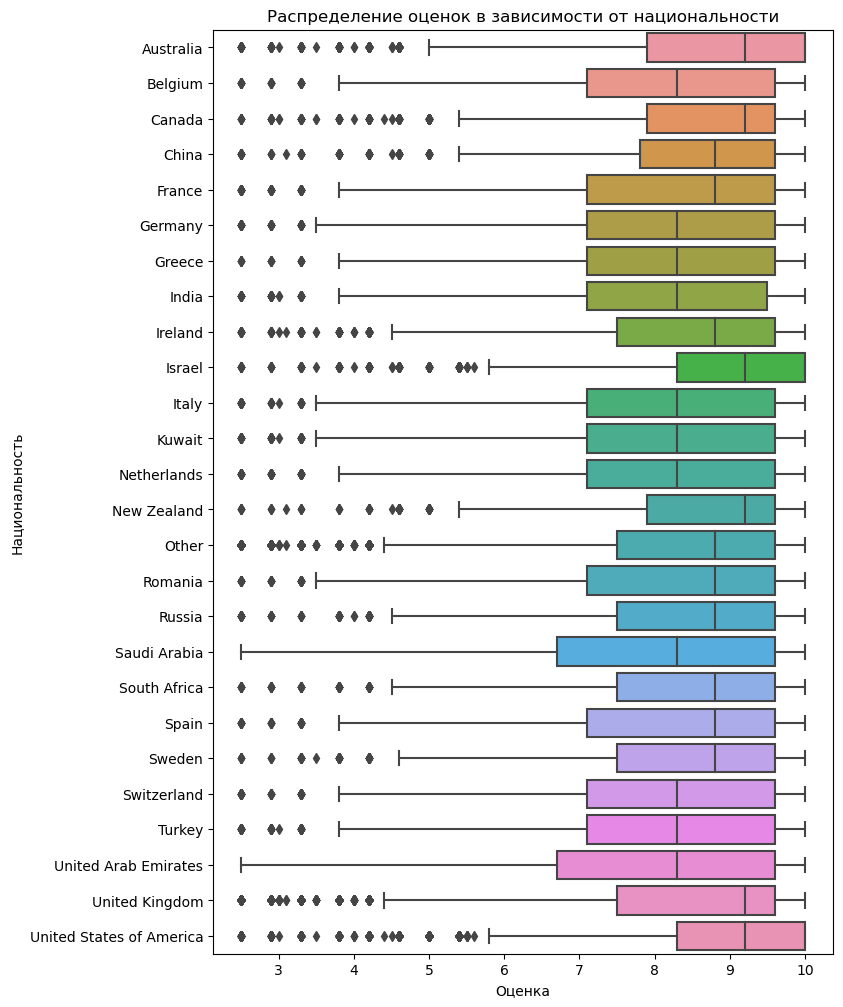

In [29]:
# посмотрим зависит ли оценка от национальности
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

# задаём маску для отбора тренировочных значений
# БУДЕТ ДЕЙСТВОВАТЬ НА ВСЕ РАСЧЁТЫ
sample_mask = data['sample'] == 1

# строим график
nationality = sns.boxplot(
    data = data[sample_mask].sort_values(by='reviewer_nationality', ascending=True),
    y = 'reviewer_nationality',
    x = 'reviewer_score',
    orient ='h',
    width = 0.8
)

# задаём названия осей и заголовок
nationality.set(xlabel='Оценка', ylabel='Национальность', title='Распределение оценок в зависимости от национальности');

Так как есть связь между оценкой рецензента и национальностью, то применим кодирование Target Encoding, таким кодированием сформируем "веса" признака 'reviewer_nationality' в зависимости от оценки рецензента. Параметры кодировщика использованы стандартные, по умолчанию.

In [30]:
# кодируем признак
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
reviewer_nationality_te = ce.TargetEncoder(
    min_samples_leaf=20, smoothing=10).fit_transform(
        data['reviewer_nationality'], data['reviewer_score'])

# переименовываем признак для удобства "отсева"
reviewer_nationality_te.rename(columns={'reviewer_nationality': 'reviewer_nationality_te'}, inplace=True)
data = pd.concat([data, reviewer_nationality_te], axis=1)

data[['reviewer_nationality', 'reviewer_nationality_te']]

reviewer_nationality  reviewer_nationality_te
0                 United Kingdom                 6.369877
1                        Belgium                 6.130857
2                         Sweden                 6.230374
3       United States of America                 6.578125
4                 United Kingdom                 6.369877
...                          ...                      ...
515733                    France                 6.189515
515734                    Turkey                 6.028747
515735               Netherlands                 6.128055
515736      United Arab Emirates                 5.872975
515737                 Australia                 6.432924

[515738 rows x 2 columns]

**2.4 Преобразование признака 'hotel_name'**

In [31]:
# собираем сводную таблицу с уникальным числом имён отелей и адресами
uniq_name = data[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name').nunique()

# отсеиваем отели с именами-дубликатами
mask_hotel_name = uniq_name['hotel_address'] != 1
hotel_name_dupl = uniq_name[mask_hotel_name].index.to_list()

# выводим число отелей с именами-дубликатами
mask_name_dupl = data['hotel_name'].isin(hotel_name_dupl)
hotel_addr_dupl = data[mask_name_dupl][['hotel_name', 'hotel_address']].value_counts()
hotel_addr_dupl

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

In [32]:
# модифицируем названия отелей, добавив в название город
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in hotel_name_dupl)
    else row['hotel_name'], axis=1)

# смотрим, что получилось
mask = data['hotel_name'].str.contains(hotel_name_dupl[0])
data[mask]['hotel_name'].value_counts()

Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

In [33]:
# кодируем hotel_name - признак не совсем информативный, просто его не стоит удалять - по нему группируются отзывы
data['hotel_name'] = data['hotel_name'].astype('category')
data['hotel_name_code'] = data['hotel_name'].cat.codes

data[['hotel_name', 'hotel_name_code']]

hotel_name  hotel_name_code
0                                   Hotel Da Vinci              612
1                                Urban Lodge Hotel             1447
2       Alexandra Barcelona A DoubleTree by Hilton               33
3                         Hotel Principe Di Savoia              735
4                                   Hotel Esther a              633
...                                            ...              ...
515733                             Hotel Moonlight              711
515734               BEST WESTERN PLUS Amedia Wien              104
515735                     Bloomsbury Palace Hotel              177
515736                      The Marble Arch London             1366
515737                       The Nadler Kensington             1373

[515738 rows x 2 columns]

**2.5 Анализ тегов**

In [34]:
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [35]:
# выведем число тегов для каждого отеля в отдельный признак
data['tags_count'] = data['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

# посмотрим сколько тегов бывает по количеству, ищем максимум 
data['tags_count'].unique()

array([4, 5, 3, 6, 2, 1])

In [36]:
# смотрим структуру признака 'tag'
print(data[data['tags_count'] == data['tags_count'].max()]['tags'].iloc[0])
print(data[data['tags_count'] == data['tags_count'].max()]['tags'].iloc[1])

[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


In [37]:
def get_tags(tags_string):
    # убираем лишнюю информацию (т.н. "мусор")
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    
    # "нарезаем" оставшуюся строку тегов во временный список
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # "кодируем" путешественника(-ов)
    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    # "кодируем" тип комнаты
    # словарь "выносится" наружу только ради графиков (для формирования меток по оси абсцисс)
    global room_types
    room_types = {
            'Other': 0,
            'Premier': 1, 'Royal': 2, 'President': 3, 'Presidential': 4, 'Ordinary': 5, 
            'Adjacent': 6, 'Exception': 7, 'Luxury': 8, 'Panoramic': 9, 'Classic': 10, 
            'Loft': 11, 'Montcalm': 12, 'Privilege': 13, 'Special': 14, 'Camper': 15, 
            'Sensation': 16, 'Classique': 17, 'Privilege': 18, 'Wonderful': 19, 'Deluxe': 20,
            'Premium': 21, 'Quadruple': 22, 'Triple': 23, 'Duplex': 24, 'Penthouse': 25, 
            'Townhouse': 26, 'Connecting': 27, 'Apartment': 28, 'Apartments': 29, 'Queen': 30, 
            'King': 31, 'Comfort': 32, 'Large': 33, 'Cosy': 34, 'Cozy': 35, 
            'Extra': 36, 'Plus': 37, 'Club': 38, 'Art': 39, 'View': 40,
            'Studio': 41, 'City': 42, 'Emotion': 43, 'Suite': 44, 'Executive': 45,
            'Superior': 46, 'Guest': 47, 'Family': 48, 'Business': 49,
    }

    # задаем начальные значения новых признаков
    tag_from_mobile = 0
    tag_with_pet = 0
    
    # по умолчанию не считаем поездку командировкой, значение по умолчанию 1
    tag_leisure_trip = 1

    # по умолчанию считаем поездку, что путешественник передвигается один и без детей
    tag_reviewer_type = 1
    
    # если отзыв оставлен и отсутствуют ключевые слова 'Stayed _ night(s)',
    # будем считать, что проведена минимально 1 ночь, значение по умолчанию 1
    tag_count_nights = 1
    
    # номер по умолчанию без видовых преимуществ
    tag_view_room = 0

    # если комната в тегах отсутствует, значение по умолчанию 0
    tag_room_type = 0

    # кодируем значения обнаруженных признаков при их наличии во временном списке
    for _tag in list(tags_list):
        # признак - "отправлено с мобильного устройства"
        if _tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(_tag)

        # признак - путешествие с домашними питомцами
        if _tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(_tag)

        # признак - поездка рабочая (командировка)
        if _tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(_tag)

        # признак - поездка не связана с работой (отпуск)
        if _tag == 'Leisure trip':
            # просто убираем тег из временного списка, т.к. значение по умолчанию 1
            # tag_leisure_trip = 1
            tags_list.remove(_tag)

        # признак - состав путешествующих
        if _tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[_tag]
            tags_list.remove(_tag)

        # признак - количество ночей
        if re.fullmatch(r'Stayed\s\d+\snight\w?', _tag):
            tag_count_nights = [int(n) for n in re.findall(r'-?\d+\.?\d*', _tag)][0]
            tags_list.remove(_tag)

        # признак - имеется тег "номер с видом на..."
        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

            # кодируем тип номера
            for r_t in room_types.keys():
                if r_t in tags_list[0]:
                    tag_room_type = room_types[r_t]

            # исключения, т.к. тег идет как 'Double or Twin Room 1 2 Adults'
            if ('Double' in tags_list[0]) | ('Twin' in tags_list[0]):
                tag_room_type = 50

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

# создаем новые признаки
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 'tag_room_type']
] = pd.DataFrame(data['tags'].apply(get_tags).to_list(), index=data.index).astype('int8')

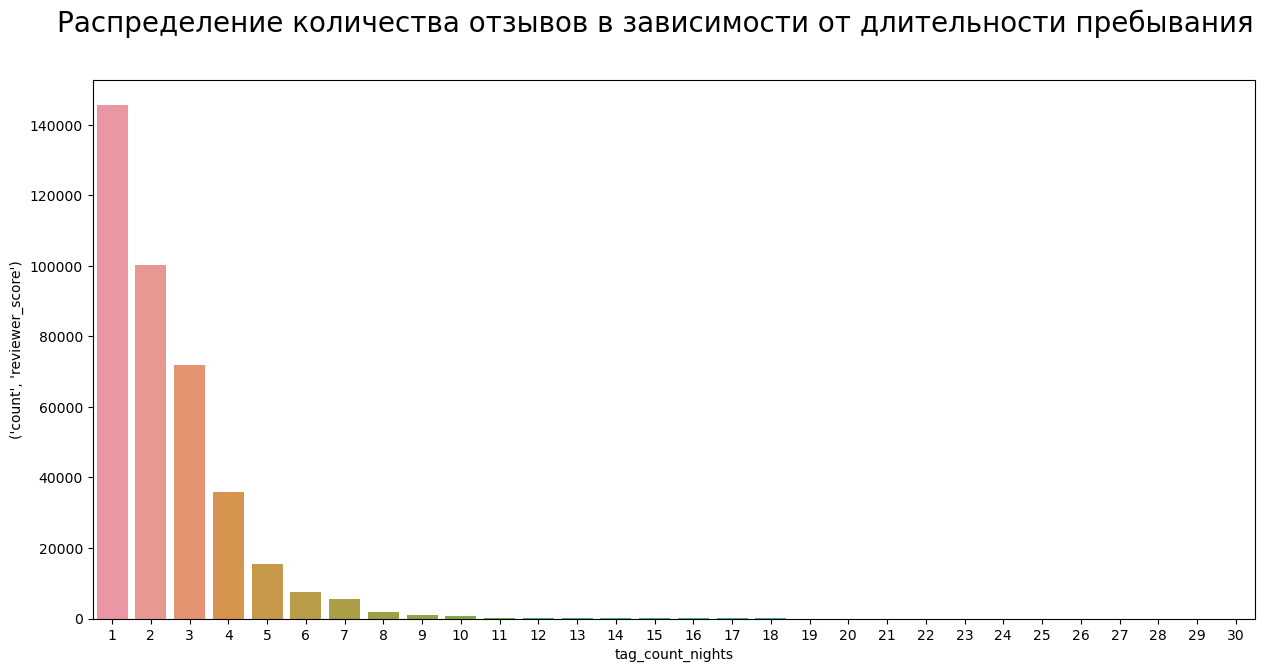

In [38]:
pivot_nights = pd.pivot_table(
    data[data['sample'] == 1], 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

In [39]:
# смотрим, что получилось
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type', 'tag_view_room']].nunique()

tag_from_mobile       2
tag_with_pet          2
tag_leisure_trip      2
tag_reviewer_type     6
tag_count_nights     31
tag_room_type        48
tag_view_room         2
dtype: int64

**2.6 Обработка отзывов**

In [40]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())
data['negative_review'].value_counts().reset_index().head(25)

index  negative_review
0               No Negative           127890
1                   Nothing            18531
2                   nothing             2508
3                      None             1166
4                       N A             1060
5                                        849
6            Nothing really              570
7                       N a              520
8                  All good              470
9                Small room              455
10            No complaints              450
11                Breakfast              449
12                 Location              421
13           Nothing at all              415
14               Everything              367
15       Nothing to dislike              335
16                     none              322
17                    Price              301
18                      Nil              269
19   Everything was perfect              247
20              Small rooms              245
21  Can t think of anything              234
22                      n a              233
23                  Leaving              220
24       Absolutely nothing              214

In [41]:
# удаляем начальные и конечные пробелы в признаке позитивных отзывов
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())
data['positive_review'].value_counts().reset_index().head(25)

index  positive_review
0                  No Positive            35946
1                     Location            10137
2                   Everything             2897
3                     location             1736
4                      Nothing             1468
5               Great location             1419
6                 The location             1341
7                Good location             1203
8                    Breakfast              664
9               Friendly staff              603
10          Excellent location              547
11                       Staff              486
12                  everything              371
13          Location and staff              371
14          Location was great              294
15           Location was good              277
16      Everything was perfect              276
17                   Comfy bed              263
18              Good breakfast              248
19           Location is great              236
20                   The staff              234
21                     nothing              234
22            Perfect location              227
23               good location              225
24  Location location location              218

In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делов подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

In [43]:
drop_list.append('hotel_name')
drop_list.append('negative_review')
drop_list.append('positive_review')
drop_list.append('neg_scores')
drop_list.append('pos_scores')
drop_list.append('tags')
drop_list.append('reviewer_nationality')

In [44]:
#удаляем признаки которые задавали в список для удаления drop_list
data.drop(drop_list, axis = 1, inplace=True)

In [45]:
# кодируем исходный признак
data_ttl_pos_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_positive_word_counts']])
data_ttl_neg_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_negative_word_counts']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_ttl_pos_words_cnts_mm = pd.DataFrame(
    data_ttl_pos_words_cnts_mm, columns=['review_ttl_pos_word_cnts_norm'])
data_ttl_neg_words_cnts_mm = pd.DataFrame(
    data_ttl_neg_words_cnts_mm, columns=['review_ttl_neg_word_cnts_norm'])

# посмотреть результаты
# display(data_ttl_pos_words_cnts_mm, data_ttl_neg_words_cnts_mm)

# добавляем к основному датасету
data = pd.concat([data, data_ttl_pos_words_cnts_mm], axis=1)
data = pd.concat([data, data_ttl_neg_words_cnts_mm], axis=1)

# соединим эти показатели в один - разностный
data['review_ttl_word_cnts_diff_norm'] = data['review_ttl_pos_word_cnts_norm'] - \
    data['review_ttl_neg_word_cnts_norm']

# добавим флаг, который показывает преобладают ли позитивные слова 
# над негативными в размерностях соответствующих диапазонов
data['more_positive_words_flag'] = data['review_ttl_word_cnts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0).astype('int8')

In [46]:
# формируем новый дополнительный признак из числа основных
data['review_total_word_counts'] = data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными - по 0.5
data['review_positive_word_proportion'] = data.apply(
    lambda x: 0.5 if x['review_total_word_counts'] == 0 \
        else (x['review_total_positive_word_counts'] / x['review_total_word_counts']),
    axis=1)

# удаление вспомогательных дополнительных признаков
data.drop(['review_ttl_pos_word_cnts_norm', 
    'review_ttl_neg_word_cnts_norm', 
    'review_ttl_word_cnts_diff_norm',
    'review_total_word_counts'], axis = 1, inplace=True)

In [47]:
# проверка результата
data[['more_positive_words_flag', 'review_positive_word_proportion']]

more_positive_words_flag  review_positive_word_proportion
0                              1                         0.543860
1                              0                         0.000000
2                              1                         0.625000
3                              1                         1.000000
4                              1                         1.000000
...                          ...                              ...
515733                         1                         1.000000
515734                         1                         1.000000
515735                         0                         0.428571
515736                         1                         1.000000
515737                         1                         0.500000

[515738 rows x 2 columns]

In [48]:
# вычисляем долю рецензий данных рецензентом от общего числа отзывов в датасете
data['ratio_of_review'] = data['total_number_of_reviews_reviewer_has_given'] / \
    data['total_number_of_reviews']

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента
data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: np.log(x + 1))

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [50]:
data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'distance_center',
       'hotel_country_code', 'hotel_city_code', 'month', 'year', 'day',
       'reviewer_nationality_te', 'hotel_name_code', 'tags_count',
       'tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip',
       'tag_reviewer_type', 'tag_count_nights', 'tag_view_room',
       'tag_room_type', 'n_review_sentiments_neg', 'n_review_sentiments_neu',
       'n_review_sentiments_pos', 'n_review_sentiments_compound',
       'p_review_sentiments_neg', 'p_review_sentiments_neu',
       'p_review_sentiments_pos', 'p_review_sentiments_compound',
       'more_positive_words_flag', 'review_positive_word_proportion',
       'ratio_of_review'],
      dtype='object')

# **3. Отбор признаков**

**3.1 Анализ мультиколлинеарности**

In [51]:
cat_cols = ['average_score',
            'lat', 'lng', 'days_since_review', 
            'hotel_country_code', 'hotel_city_code', 'month', 'year', 'day', 'reviewer_nationality_te',
            'hotel_name_code',
            'tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip',
            'tag_count_nights', 'tag_view_room', 'n_review_sentiments_neg',
            'more_positive_words_flag'
            ] 
 
num_cols = ['additional_number_of_scoring', 
            'total_number_of_reviews', 
            'review_total_negative_word_counts',
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'distance_center', 'tags_count',
            'n_review_sentiments_neg', 'n_review_sentiments_neu',
            'n_review_sentiments_pos', 'n_review_sentiments_compound',
            'p_review_sentiments_neg', 'p_review_sentiments_neu',
            'p_review_sentiments_pos', 'p_review_sentiments_compound', 
            'review_positive_word_proportion',
            'ratio_of_review'
           ]

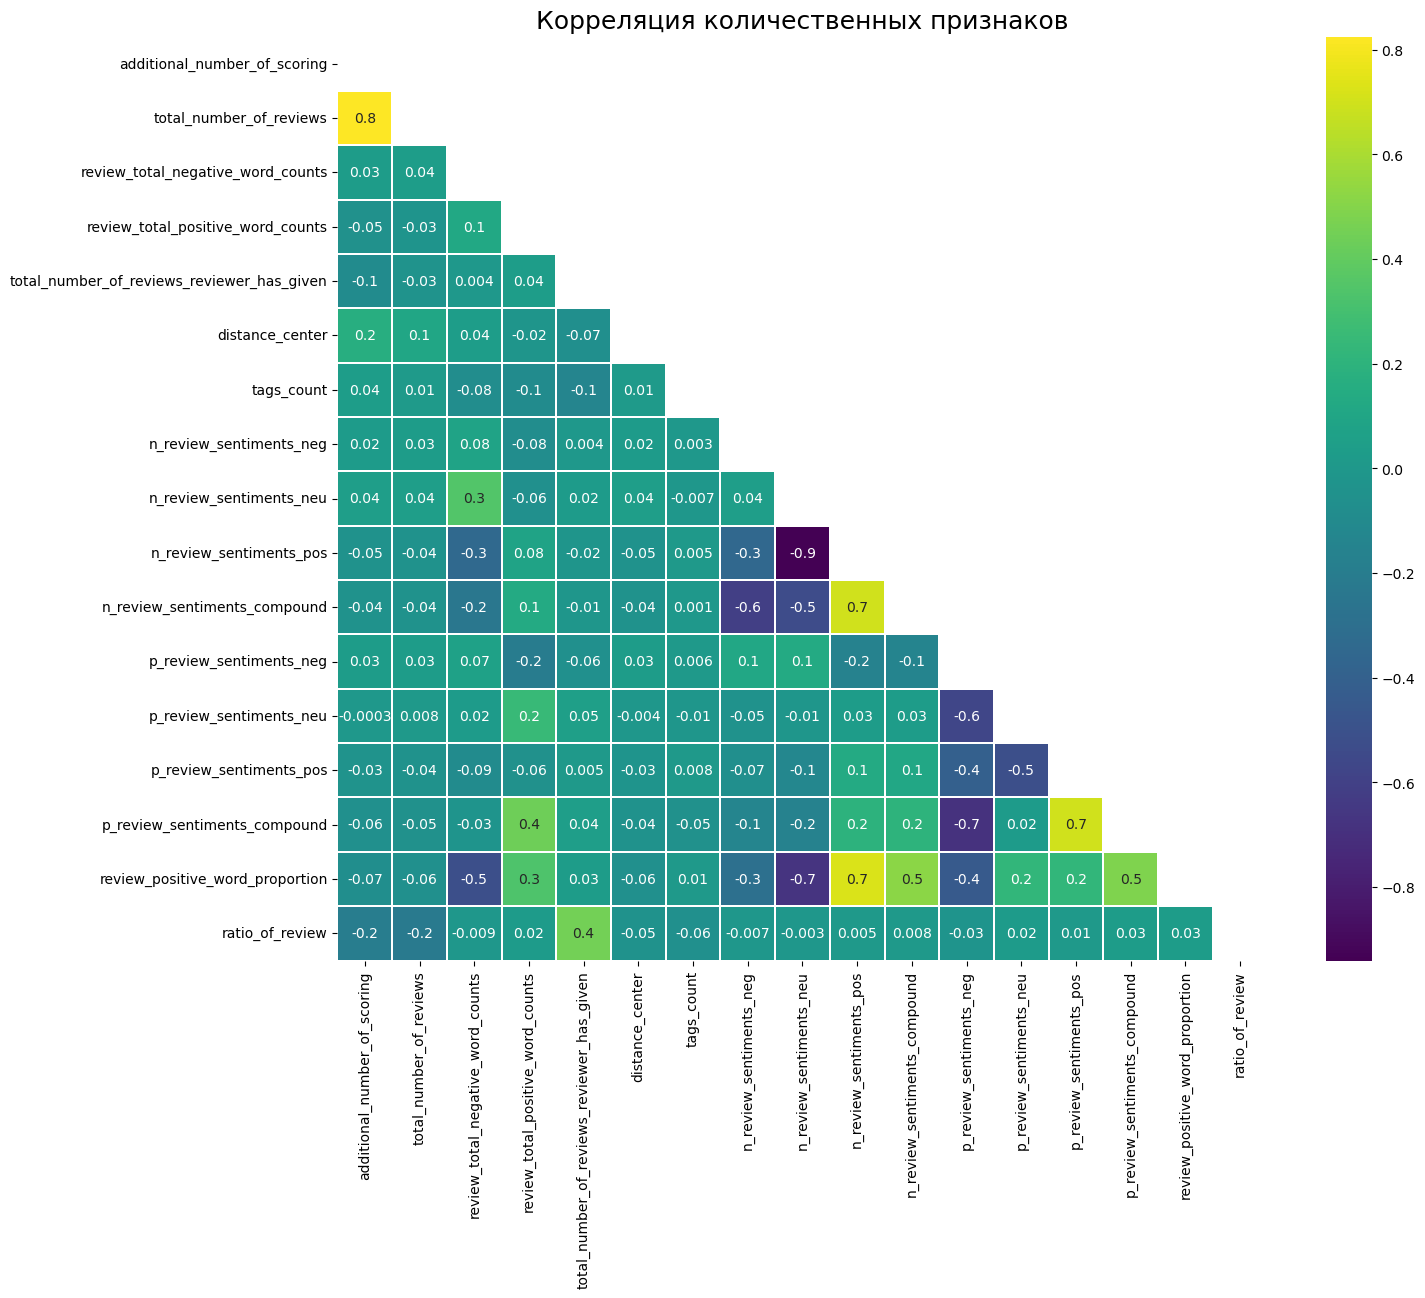

In [52]:
#Построим тепловую диаграмму корреляции количественных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[num_cols].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1g')
ax_.set_title('Корреляция количественных признаков', fontsize=18)
plt.show()

In [53]:
#Отметим количественные признаки с корреляцией больше 0,8
del_cols = ['n_review_sentiments_neu', 'additional_number_of_scoring']

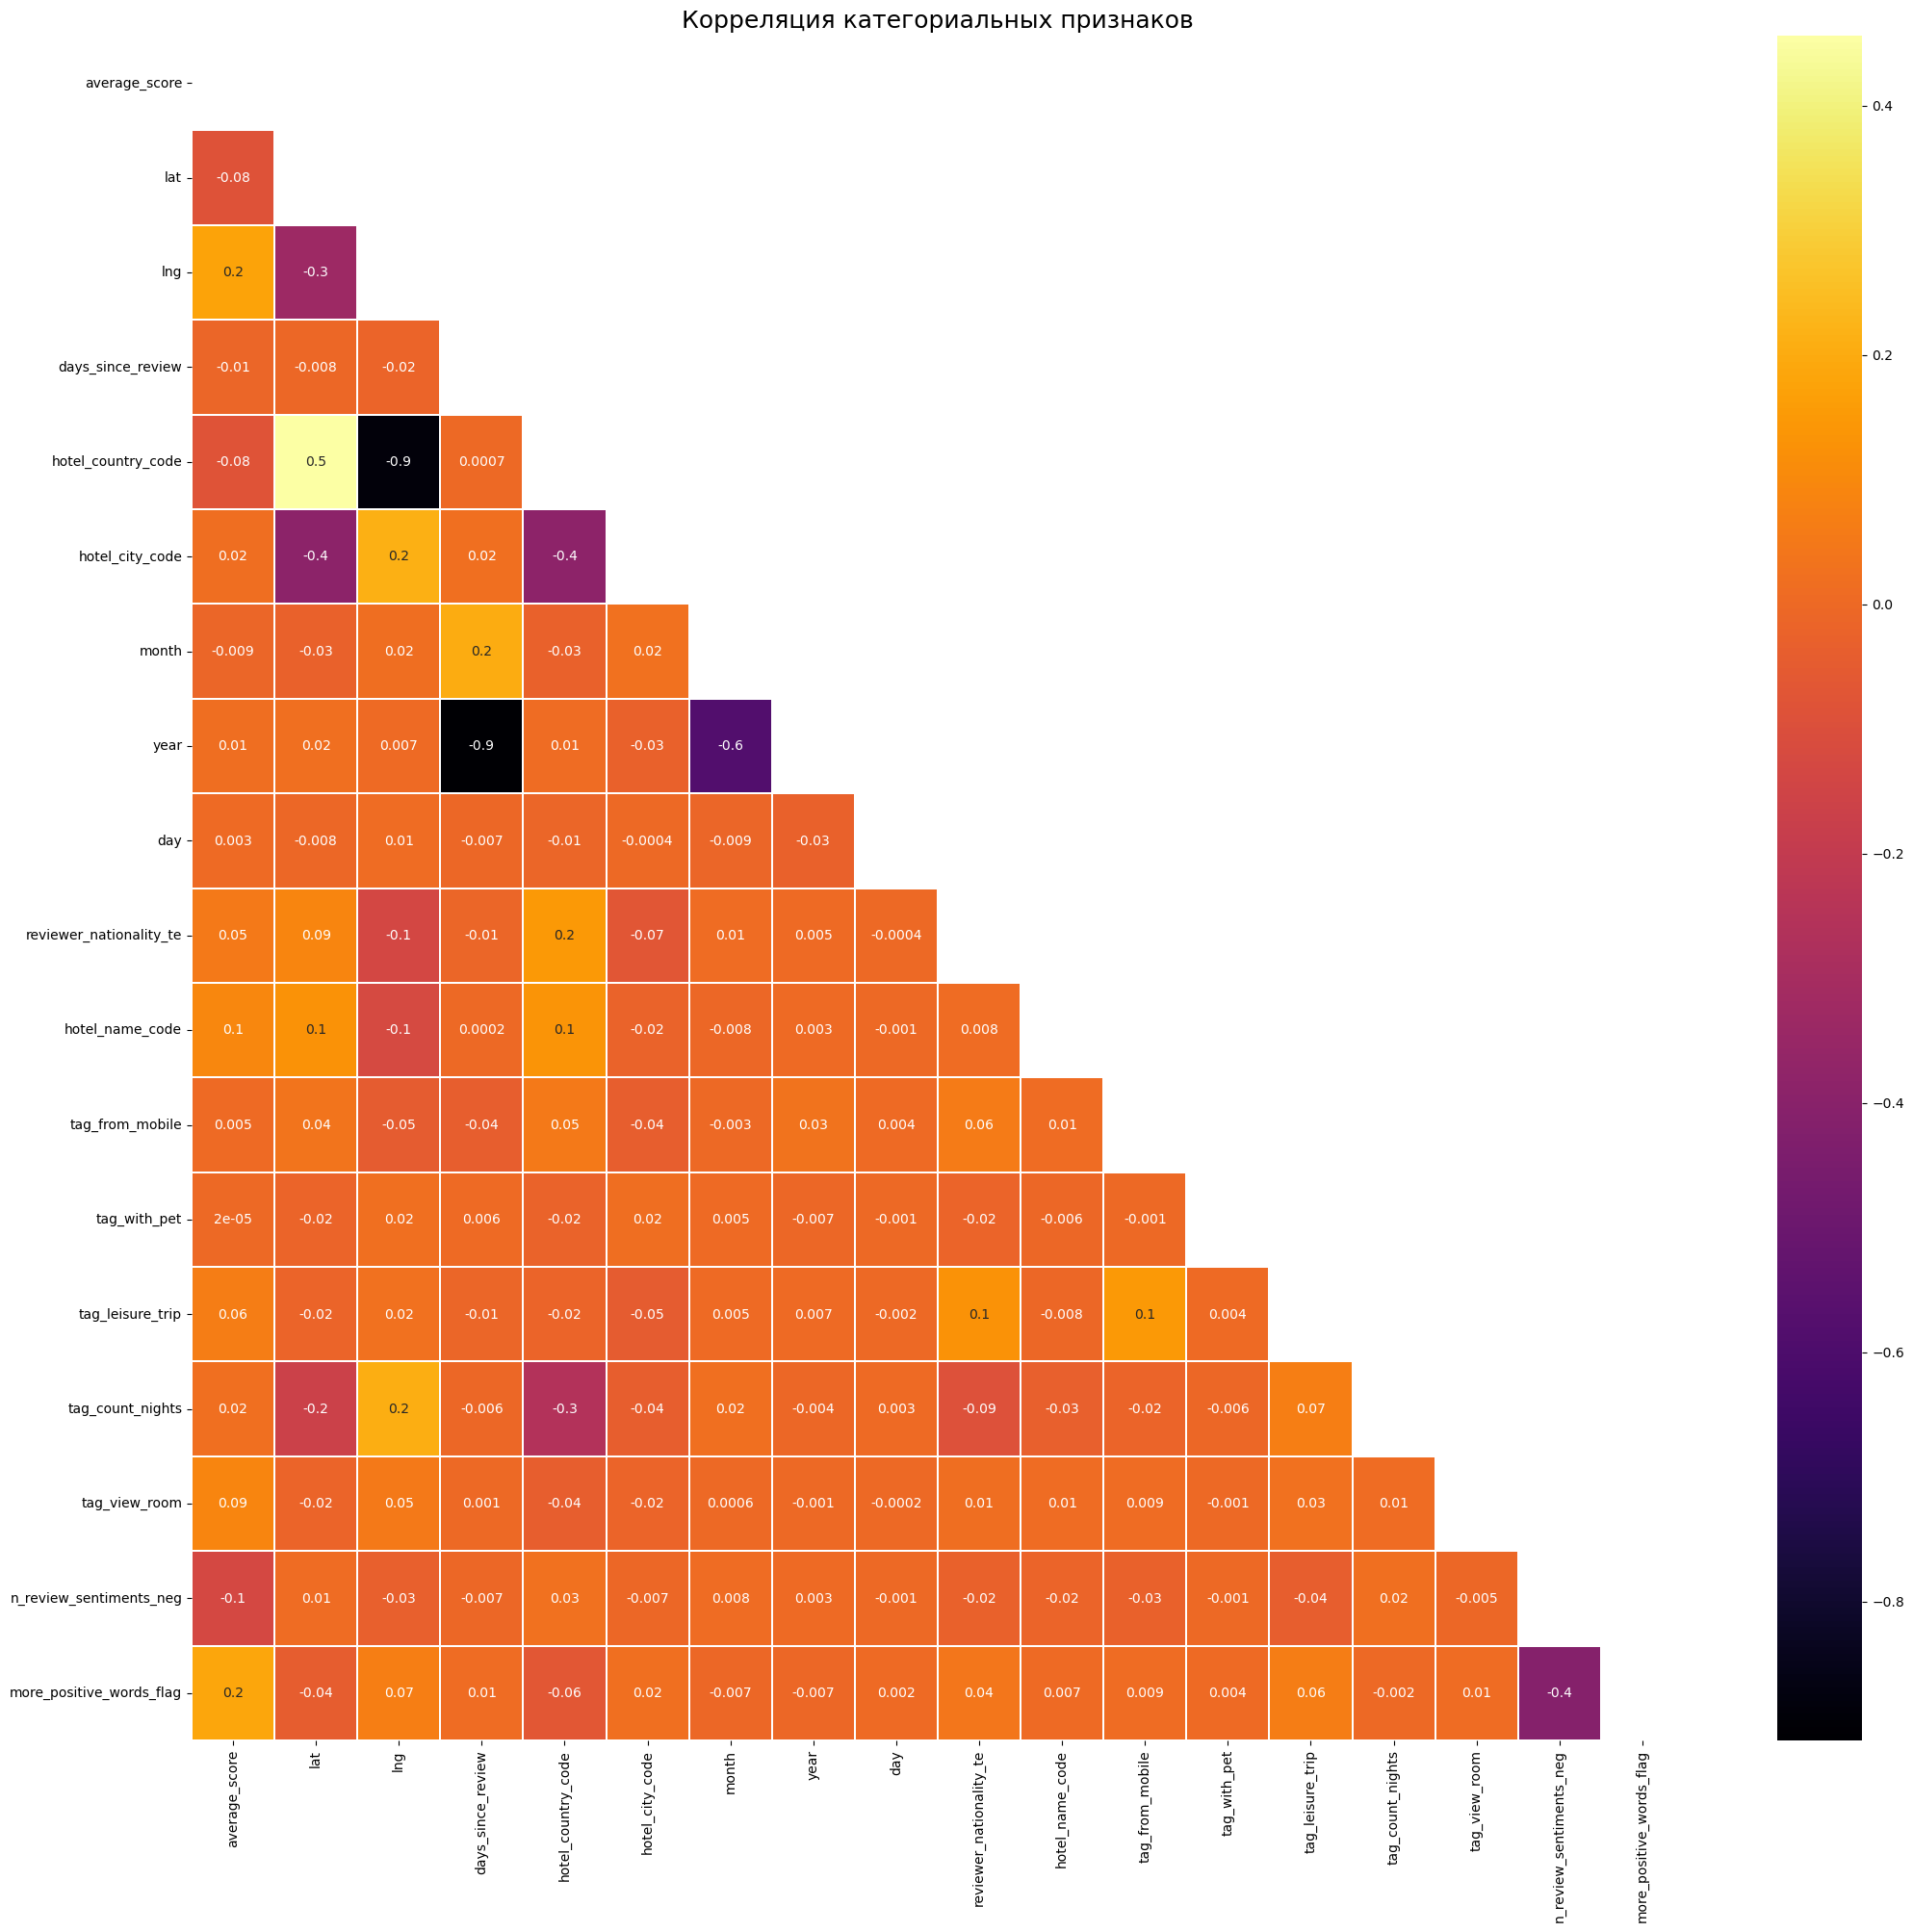

In [54]:
#Построим тепловую диаграмму корреляции категориальных признаков
fig_, ax_ = plt.subplots(figsize=(25, 23))
corr = data[cat_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='inferno',
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=18)
plt.show()


In [55]:
#Отметим категориальные признаки с корреляцией больше 0,8
del_cols += ['lng', 'lat'
            ]

In [56]:
#Удаляем признаки, попавшие в список del_cols
data.drop(del_cols, axis = 1, inplace=True)
print('Осталось признаков: {}'.format(data.shape[1]))

Осталось признаков: 34


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 5   days_since_review                           515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   distance_center                             515738 non-null  float64
 9   hotel_country_code                          515738 non-null  int8   
 

**3.2 Оценка значимости**

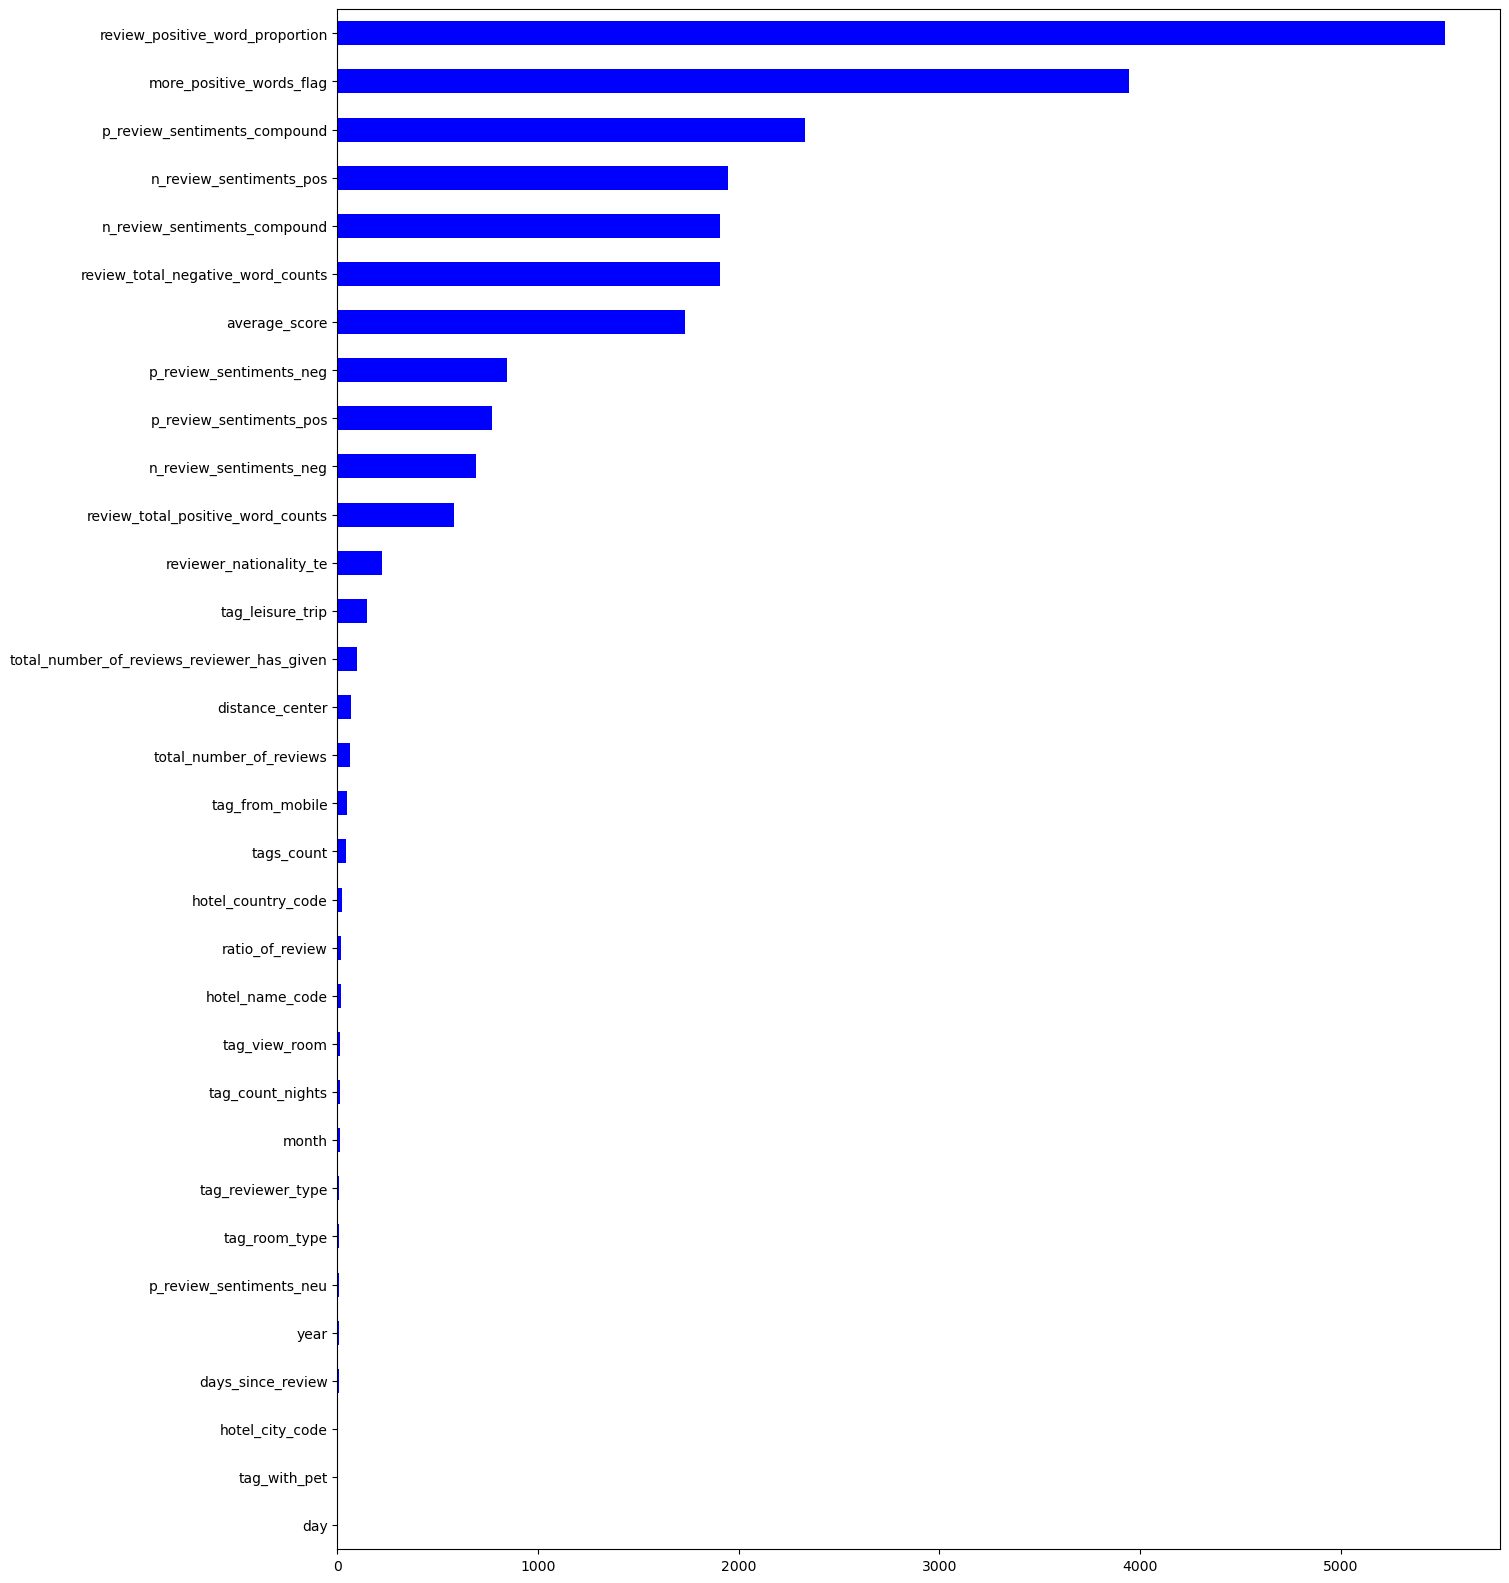

In [58]:
#Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для числовых признаков — тест ANOVA:
y = data.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='blue');

In [59]:
#Также удалим признаки, почти не коррелирующие с целевым показателем
cols_for_del = ['tag_with_pet']
data.drop(cols_for_del, axis = 1, inplace=True)
print('ВСЕГО ПРИЗНАКОВ: {}'.format(data.shape[1]))

ВСЕГО ПРИЗНАКОВ: 33


# **4. Обучение модели и получение предсказания**

**4.1 Вариант обучения модели с помощью модуля RandomForestRegressor**

In [60]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

In [61]:
model = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [62]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: user 14min 19s, sys: 2.84 s, total: 14min 22s
Wall time: 3min 41s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [63]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.51


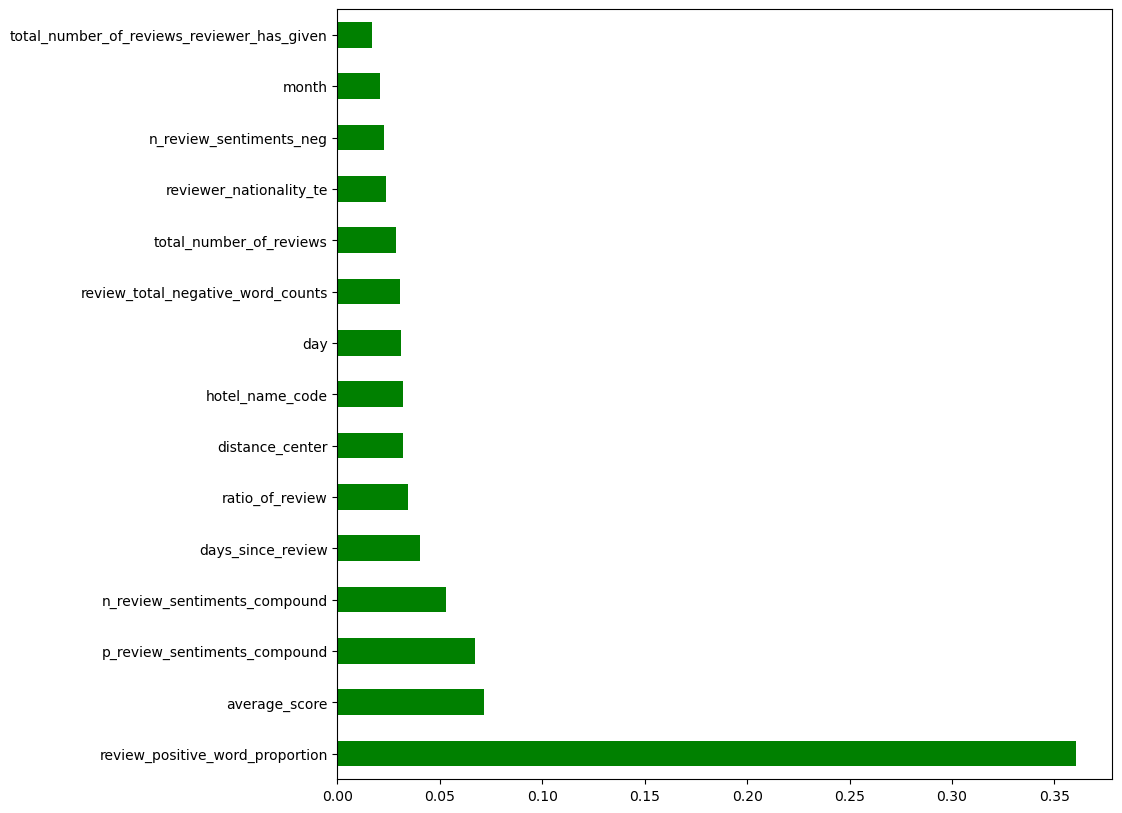

In [64]:
# Особенности важности

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

In [65]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission_rand_forest_regr2.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


reviewer_score      id
0           8.559  488440
1           7.636  274649
2           8.057  374688
3           9.662  404352
4           9.511  451596
5           8.991  302161
6           7.919  317079
7           7.350   13963
8           8.601  159785
9           7.514  195089

**4.2 Вариант обучения модели с помощью модуля LightAutoML**

In [66]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# setting constants for lightautoml
N_THREADS = 10
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 5000 
TARGET_NAME = 'reviewer_score'

# for reproducibility
np.random.seed(RANDOM_STATE)

In [67]:
# разбиение на тренировочную и валидационную модели
# tr_data - тренировочные данные
# te_data - холдаут
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

In [68]:
# Task - объект из lightautoml
# Определяем какую задачу мы решаем: бинарную 'binary', регрессии 'reg', мультикласс 'multiclass'
# В данном случае регрессия - так как предсказываем вещественное число

task = Task('reg', loss = 'mae', metric = 'mae')
# какая колонка является целевой? и какие колонки лишние
roles = {
    'target': TARGET_NAME,
    'drop': []
}

# Создаем объект TabularAutoML

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)



# Начало обучения модели (на каких данных обучаем, какой target, уровень отображения)
# После выполнения обучения мы получаем Out OF Folde пердсказание

oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

# Информация о работе automl
# print(automl.create_model_str_desc())


[06:26:29] Stdout logging level is INFO.
[06:26:29] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[06:26:29] Task: reg

[06:26:29] Start automl preset with listed constraints:
[06:26:29] - time: 5000.00 seconds
[06:26:29] - CPU: 10 cores
[06:26:29] - memory: 16 GB

[06:26:29] Train data shape: (270762, 32)

[06:26:38] Layer 1 train process start. Time left 4991.54 secs
[06:26:58] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:27:14] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.8970786327594777
[06:27:14] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:27:14] Time left 4955.18 secs

[06:27:47] Selector_LightGBM fitting and predicting completed
[06:28:08] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:34:16] Time limit exceeded after calculating fold 6

[06:34:16] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8302910692889272
[06:34:16] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting com

In [69]:
%%time

# обучение валидационной выборки
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5.172462 ],
       [8.037608 ],
       [9.236025 ],
       ...,
       [9.526083 ],
       [7.5816283],
       [9.842962 ]], dtype=float32)
Shape = (116041, 1)
CPU times: user 3min 15s, sys: 148 ms, total: 3min 15s
Wall time: 53.7 s


CPU times: user 229 ms, sys: 148 ms, total: 377 ms
Wall time: 140 ms


<AxesSubplot:xlabel='Feature'>

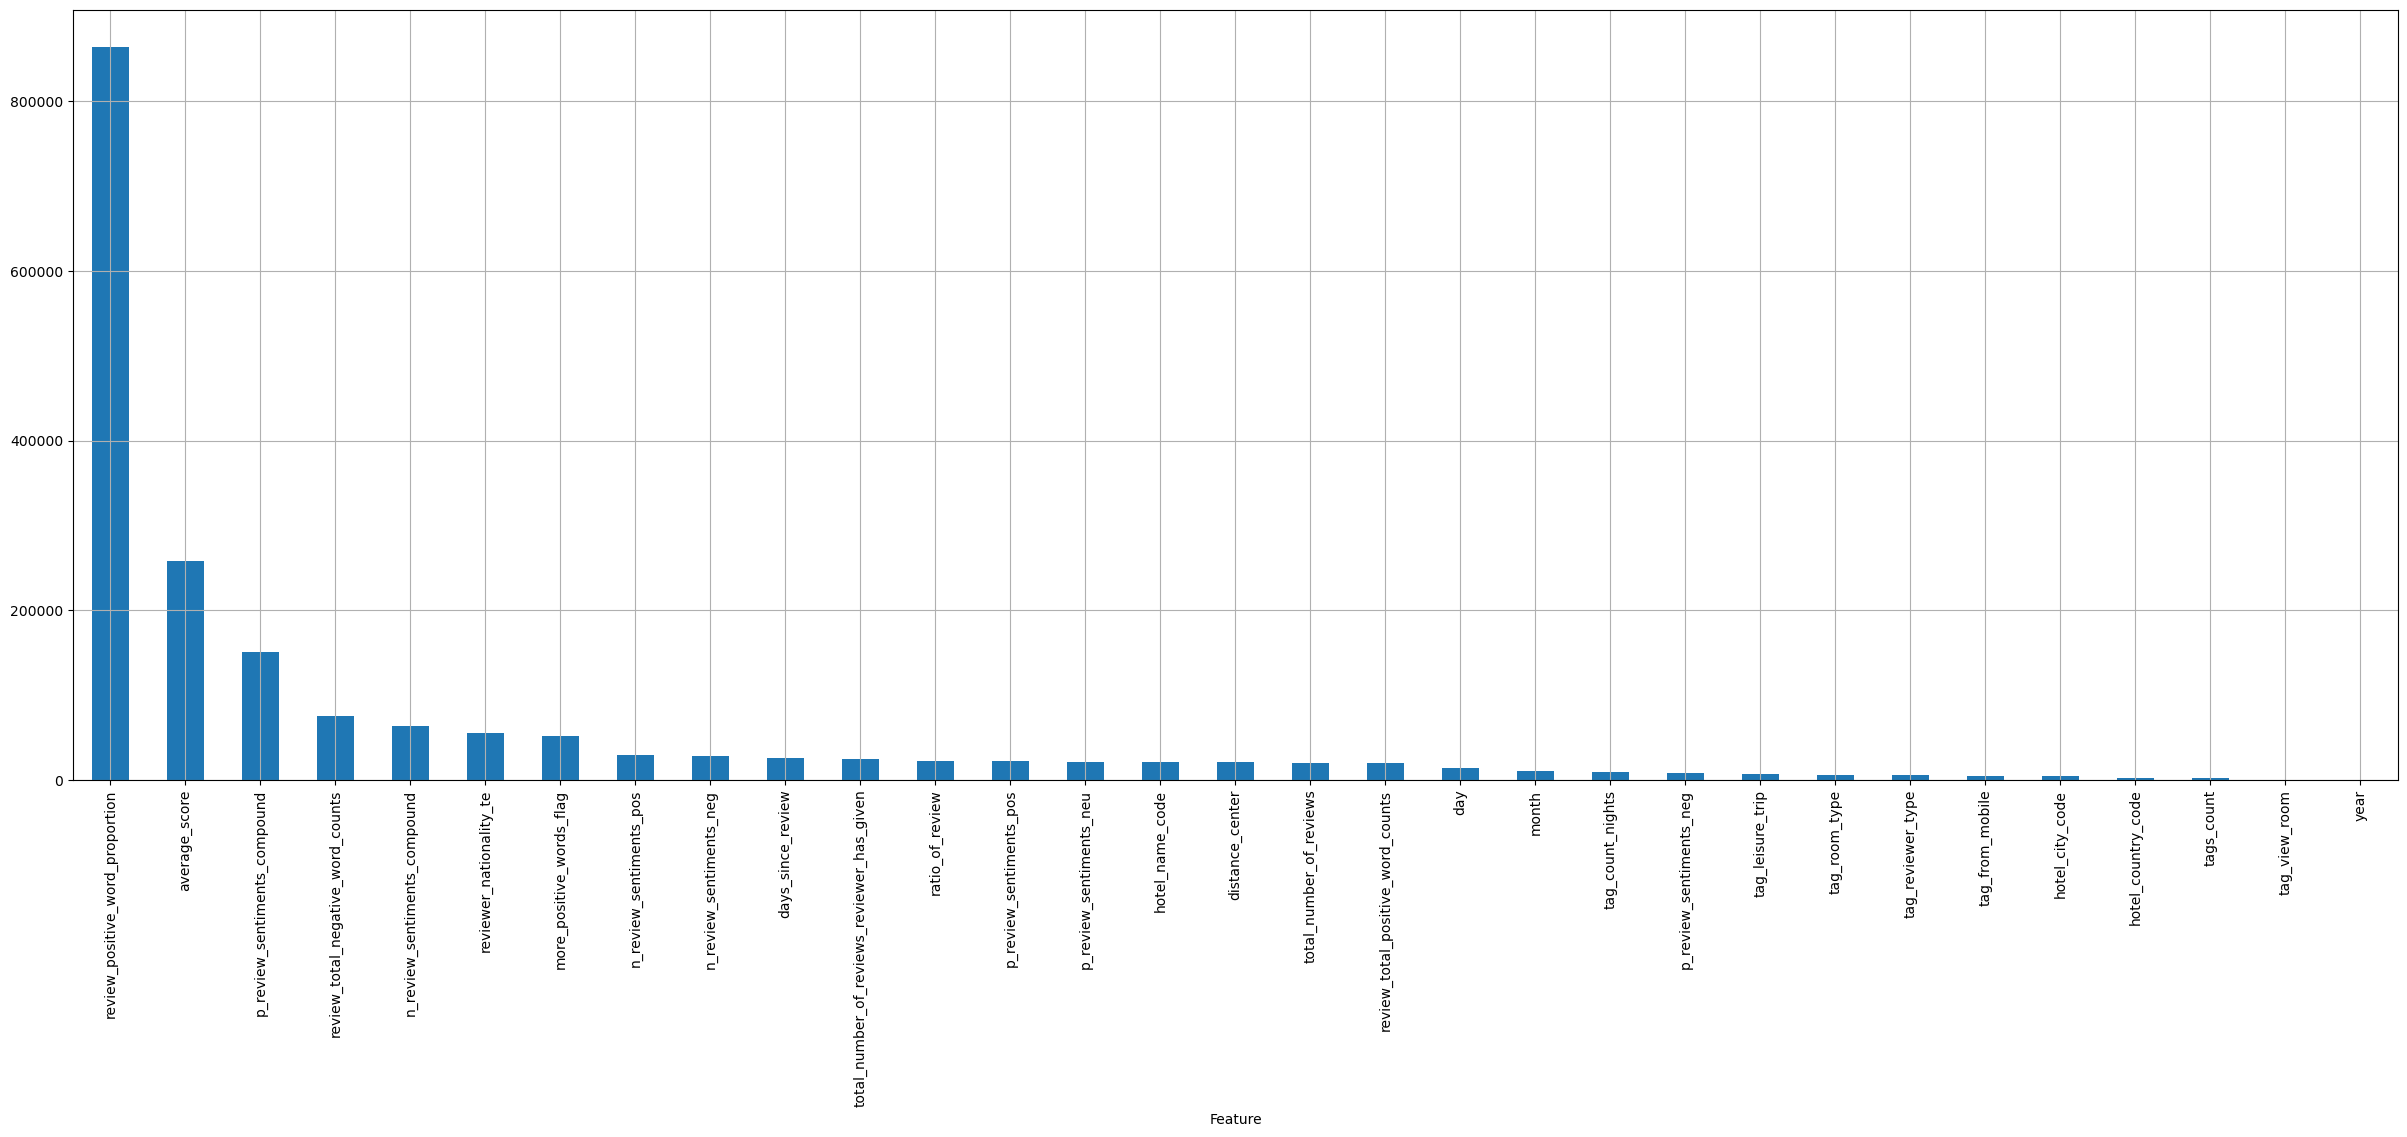

In [70]:
%%time

# оцениваем важность признаков в графическом виде - быстрый способ оценки параметров
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

In [71]:
# оцениваем модель 
mae_automl = metrics.mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]).round(8)
mape_automl = (metrics.mean_absolute_percentage_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]) * 100).round(8)
print(f'MAE: {mae_automl}\nMAPE: {mape_automl}')

MAE: 0.82756676
MAPE: 12.14971577


In [72]:
# предсказание целевой переменной
predict_submission = automl.predict(test_data)
print(f'Prediction for te_data:\n{predict_submission}\nShape = {predict_submission.shape}')

Prediction for te_data:
array([[8.847181 ],
       [7.9821153],
       [8.495872 ],
       ...,
       [8.124028 ],
       [9.797042 ],
       [7.716086 ]], dtype=float32)
Shape = (128935, 1)


In [73]:
# сохрание результата (сабмишн для загрузки и оценки)
sample_submission[TARGET_NAME] = predict_submission.data[:, 0]

# sample_submission.to_csv(INPUT_DIR + 'submission_tabular_automl.csv', index = False)
sample_submission.to_csv('submission_tabular_automl2.csv', index = False)

# знакомимся с данными
sample_submission.head(10)

reviewer_score      id
0        8.847181  488440
1        7.982115  274649
2        8.495872  374688
3        9.889632  404352
4        9.877722  451596
5        8.885348  302161
6        7.836758  317079
7        7.832783   13963
8        8.953059  159785
9        7.915592  195089

In [74]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt